### 1. 이미지 로드 및 전처리

In [1]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms


In [2]:
# 함수 정의: 이미지 로드 + Transform
def load_image(img_url, max_size=400):
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    size = max(image.size) if max(image.size) < max_size else max_size
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

In [3]:
# 함수 정의: Tensor -> 이미지 변환
def image_convert(tensor):
    image = tensor.to("cpu").clone().detach().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225]
    image = image + [0.485, 0.456, 0.406]
    return image.clip(0, 1)

https://github.com/pytorch/tutorials/blob/main/_static/img/neural-style/dancing.jpg<br>
https://github.com/pytorch/tutorials/blob/main/_static/img/neural-style/picasso.jpg<br>
https://github.com/pytorch/tutorials/blob/main/_static/img/neural-style/neuralstyle.png<br>

In [4]:
# 이미지 url
content_url = 'https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg'
style_url = 'https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg'

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 로드
content = load_image(content_url).to(device)
style = load_image(style_url).to(device)

In [8]:
content

tensor([[[[-1.3644, -1.3473, -1.3302,  ..., -1.9809, -2.0152, -2.0494],
          [-1.3302, -1.3473, -1.3644,  ..., -1.9638, -1.9809, -2.0152],
          [-1.3302, -1.3987, -1.4158,  ..., -1.9638, -1.9809, -1.9980],
          ...,
          [-0.7993, -0.8507, -0.9020,  ..., -1.2103, -1.1932, -1.2445],
          [-0.8507, -0.9020, -0.9534,  ..., -1.1932, -1.1932, -1.2274],
          [-0.8849, -0.9020, -0.9363,  ..., -1.1932, -1.1760, -1.2274]],

         [[-1.3529, -1.3354, -1.3179,  ..., -1.9132, -1.9482, -1.9832],
          [-1.3179, -1.3354, -1.3529,  ..., -1.8957, -1.9132, -1.9482],
          [-1.3179, -1.3880, -1.4055,  ..., -1.8957, -1.9132, -1.9307],
          ...,
          [-0.7577, -0.8102, -0.8627,  ..., -1.1779, -1.1604, -1.2129],
          [-0.8102, -0.8627, -0.9153,  ..., -1.1604, -1.1604, -1.1954],
          [-0.8452, -0.8627, -0.8978,  ..., -1.1604, -1.1429, -1.1954]],

         [[-1.2293, -1.2119, -1.1944,  ..., -1.7173, -1.7522, -1.7870],
          [-1.1944, -1.2119, -

In [10]:
style

tensor([[[[-1.3302, -1.4672, -1.4672,  ..., -0.3883, -0.5253, -0.4911],
          [-1.4843, -1.5014, -1.4500,  ..., -0.4739, -0.5253, -0.5082],
          [-1.5014, -1.3987, -1.3987,  ..., -0.3027, -0.3198, -0.3541],
          ...,
          [-1.4329, -1.3987, -1.4158,  ..., -1.5357, -1.5014, -1.5014],
          [-1.4843, -1.3987, -1.3987,  ..., -1.5357, -1.5357, -1.5528],
          [-1.4500, -1.3302, -1.3644,  ..., -1.5185, -1.5870, -1.6213]],

         [[-0.8803, -1.0203, -1.0203,  ..., -0.0924, -0.2675, -0.2325],
          [-1.0378, -1.0553, -1.0028,  ..., -0.2150, -0.2850, -0.2675],
          [-1.0203, -0.9328, -0.9153,  ..., -0.0574, -0.0924, -0.1275],
          ...,
          [-1.0203, -0.9853, -1.0028,  ..., -1.1954, -1.1604, -1.1604],
          [-1.0728, -1.0028, -1.0028,  ..., -1.1954, -1.1779, -1.1954],
          [-1.0903, -0.9678, -1.0028,  ..., -1.1429, -1.2129, -1.2479]],

         [[-0.5321, -0.6367, -0.6367,  ..., -0.0441, -0.2358, -0.2010],
          [-0.6890, -0.6890, -

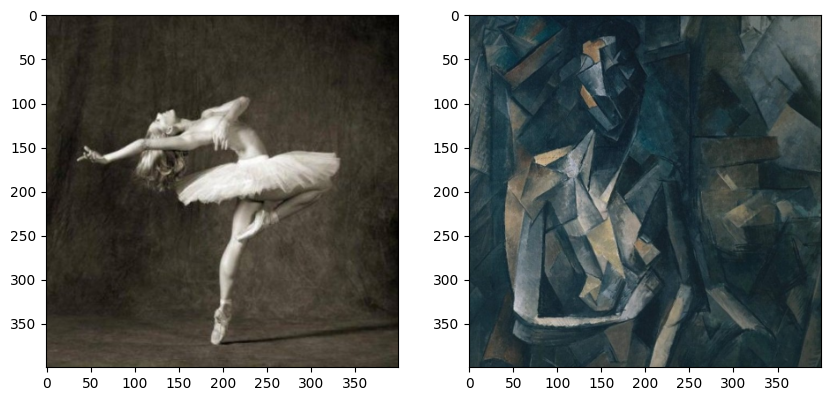

In [14]:
import matplotlib.pyplot as plt
# 이미지 표시
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_convert(content))
plt.subplot(1, 2, 2)
plt.imshow(image_convert(style))

### 2. 모델 로드

In [6]:
import torchvision.models as models

# 모델 로드 (특징 추출 레이어)
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad_(False)

c:\Users\Playdata\anaconda3\envs\llm_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Playdata\anaconda3\envs\llm_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 특징 추출 함수
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    features = {}
    
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

In [8]:
# 스타일 표현을 위한 행렬(채널간 관계) 계산 함수
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())


In [18]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {feature: gram_matrix(style_features[feature]) for feature in style_features}

target = content.clone().requires_grad_(True)
optim = torch.optim.Adam([target], lr=0.003)
style_weights = 1e-6
content_weight = 1

In [25]:
# 스타일 전이 학습
for i in range(200):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for i in style_grams:
        target_gram = gram_matrix(target_features[i])
        style_gram = style_grams[i]
        layer_loss = torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss / (target_features[i].shape[1] ** 2)

    total_loss = content_weight * content_loss + style_weights * style_loss
    optim.zero_grad()
    total_loss.backward()
    optim.step()

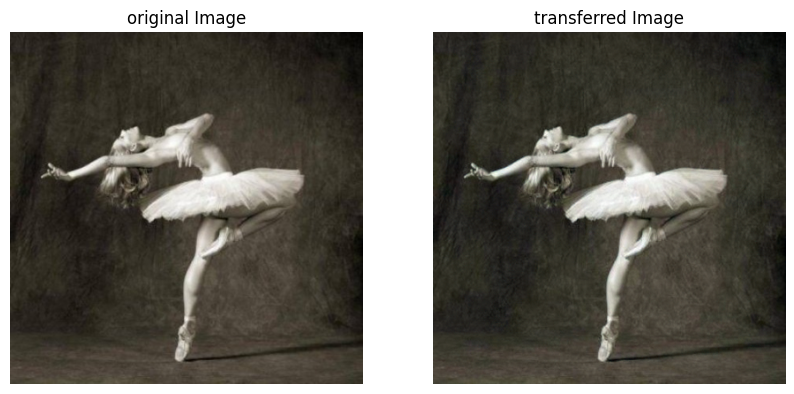

In [26]:
# 결과 확인

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_convert(content))
plt.title('original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_convert(target))
plt.title('transferred Image')
plt.axis('off')

plt.show()

### 스타일 전이 학습

- 스타일 이미지 1장 + 콘텐츠 이미지 3

In [9]:
# 3d animation_style url
content_url1 = 'https://flexible.img.hani.co.kr/flexible/normal/856/886/imgdb/original/2021/0808/20210808501986.jpg'
content_url2 = 'https://dimg.donga.com/wps/NEWS/IMAGE/2023/05/13/119270724.2.jpg'
content_url3 = 'https://img.insight.co.kr/static/2018/06/13/700/9b09v52y47pl24v1q1mp.jpg'
style_url = 'https://api.prpt.ai/image/85c2479f-2833-480c-bb83-8b948a736555'

In [10]:
# 스타일 이미지 1장으로 콘텐츠 이미지 3장 학습해서 결과 시각화하기

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 로드
content1 = load_image(content_url1).to(device)
content2 = load_image(content_url2).to(device)
content3 = load_image(content_url3).to(device)
style = load_image(style_url).to(device)

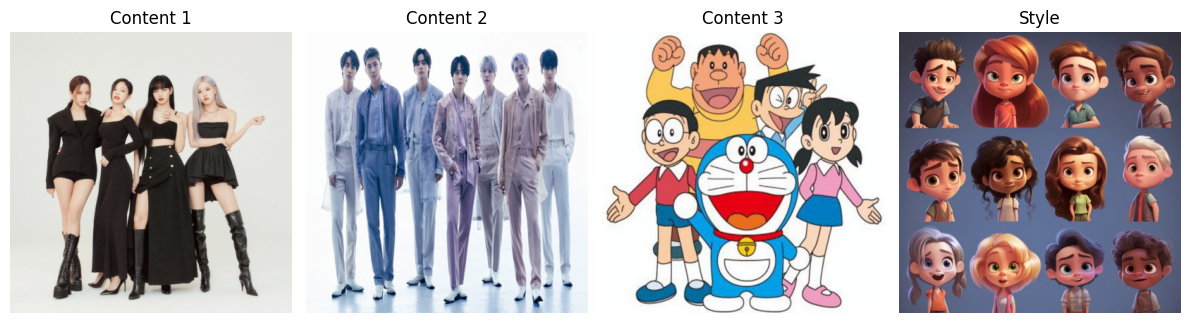

In [11]:
import matplotlib.pyplot as plt
# 이미지 표시
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(image_convert(content1))
plt.title('Content 1')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(image_convert(content2))
plt.title('Content 2')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(image_convert(content3))
plt.title('Content 3')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(image_convert(style))
plt.title('Style')
plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# 특징 추출 함수를 이용해서 특징 추출하기 (for문 사용)

contents = [content1, content2, content3]
content_features_list = []

for i, content_img in enumerate(contents, 1):
    features = get_features(content_img, vgg)
    content_features_list.append(features)
    globals()[f"content{i}_features"] = features  # content1_features, content2_features, content3_features 변수에 저장

style_features = get_features(style, vgg)
style_grams = {feature: gram_matrix(style_features[feature]) for feature in style_features}

# 3개의 contents 각각에 대해 target, optim, weight를 준비합니다.
targets = [content_img.clone().requires_grad_(True) for content_img in contents]
optims = [torch.optim.Adam([tgt], lr=0.003) for tgt in targets]
style_weights = [1e-6] * 3
content_weights = [1] * 3

In [15]:
# 각 content를 스타일 전이 학습 후 시각화하기

num_steps = 1500

# 여러 content 이미지에 대해 스타일 전이 학습 및 결과 저장
stylized_results = []

for i, (target, content_features, optimizer) in enumerate(zip(targets, content_features_list, optims), 1):
    for step in range(num_steps):
        target_features = get_features(target, vgg)
        
        # content loss
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
        # style loss
        style_loss = 0
        for layer in style_grams:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / len(style_grams)
        
        total_loss = content_weights[i-1] * content_loss + style_weights[i-1] * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    stylized_results.append(target.clone().detach())


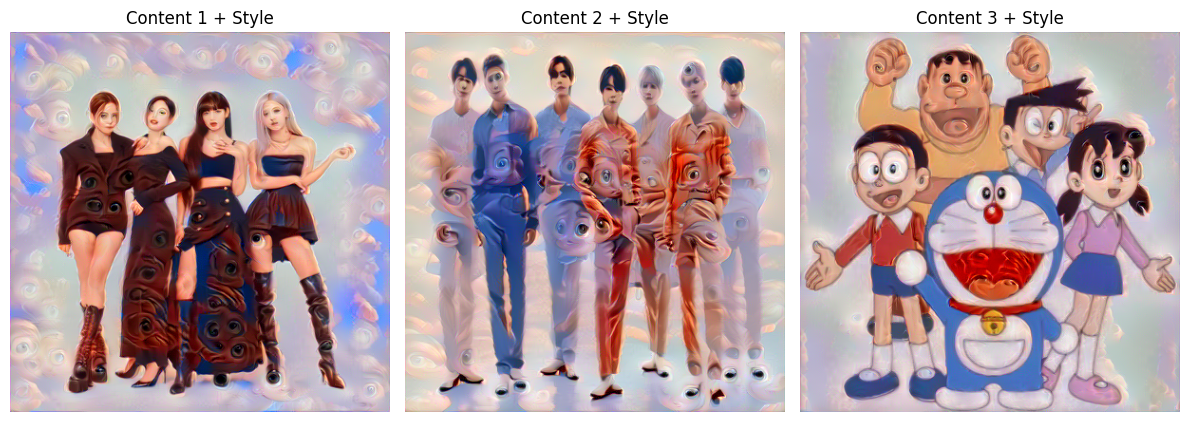

In [16]:
# 스타일 전이된 이미지 시각화
plt.figure(figsize=(12,6))
for i, result in enumerate(stylized_results, 1):
    plt.subplot(1, 3, i)
    plt.imshow(image_convert(result))
    plt.title(f"Content {i} + Style")
    plt.axis('off')
plt.tight_layout()
plt.show()